#1. Importar librerías

* Importamos librerias
* Verificamos que se este usando la GPU de Colab
* Cargamos la data desde el drive
* Verificamos que tipo de imagenes estamos trabajando









In [ ]:
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report

In [ ]:
# Verificar GPU
print("\nGPU disponible:", "Sí" if tf.config.list_physical_devices('GPU') else "No")


GPU disponible: Sí


In [ ]:
# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Configurar rutas
dataset_dir = '/content/drive/MyDrive/dataset'
model_dir = '/content/drive/MyDrive/Modelos'  # Carpeta para guardar el modelo


In [ ]:
# 1. Verificación de estructura del dataset
def verify_dataset_structure(dataset_path, expected_classes):
    print("🔍 Verificando estructura del dataset...")
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Directorio no encontrado: {dataset_path}")

    detected_classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])

    if detected_classes != expected_classes:
        print(f"⚠️ Error: Clases detectadas {detected_classes} no coinciden con las esperadas {expected_classes}")
        return False

    # Verificar 5 imágenes aleatorias por clase
    for class_name in detected_classes:
        class_path = os.path.join(dataset_path, class_name)
        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if len(images) < 5:
            print(f"⚠️ Clase {class_name} tiene menos de 5 imágenes")
            return False

        # Mostrar ejemplo de imagen
        img_path = os.path.join(class_path, images[0])
        img = tf.keras.preprocessing.image.load_img(img_path)
        if img.mode != 'RGB':
            print(f"⚠️ Imagen {img_path} no está en formato RGB")
            return False

    print("✅ Estructura del dataset validada correctamente")
    return True

# Lista de clases esperadas
expected_classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic']

if not verify_dataset_structure(dataset_dir, expected_classes):
    raise ValueError("Problemas detectados en el dataset. Verificar estructura y archivos.")

🔍 Verificando estructura del dataset...
✅ Estructura del dataset validada correctamente


In [ ]:
# Función para contar imágenes
def count_images(directory):
    categories = sorted(os.listdir(directory))
    counts = {}
    total = 0

    print("\n🔍 Analizando estructura del dataset...")
    for category in categories:
        cat_path = os.path.join(directory, category)
        if os.path.isdir(cat_path):
            images = [f for f in os.listdir(cat_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            counts[category] = len(images)
            total += len(images)

    print("✅ Análisis completado")
    return counts, total

In [ ]:
# Función para visualización de imagenes
def display_category_samples(directory, category, num_samples=3):
    cat_path = os.path.join(directory, category)
    images = sorted(glob(os.path.join(cat_path, '*.jp*')))[:num_samples]

    if not images:
        print(f"\n⚠️ No se encontraron imágenes en {category}")
        return

    plt.figure(figsize=(15, 5))
    plt.suptitle(f'Categoría: {category.upper()}', fontsize=16, y=1.05, fontweight='bold')

    for i, img_path in enumerate(images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(os.path.basename(img_path) + "\n" + f"{img.shape[1]}x{img.shape[0]}px",
                 fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Conteo de imágenes
counts, total = count_images(dataset_dir)

# Mostrar estadísticas
print("\n📊 REPORTE DEL DATASET")
print(f"📍 Ubicación: {dataset_dir}")
print(f"📂 Categorías detectadas: {len(counts)}")
print(f"🖼️ Total de imágenes: {total}\n")
for category, count in counts.items():
    print(f"• {category.upper():<12} {count:>4} imágenes ({count/total:.1%})")



🔍 Analizando estructura del dataset...
✅ Análisis completado

📊 REPORTE DEL DATASET
📍 Ubicación: /content/drive/MyDrive/dataset
📂 Categorías detectadas: 5
🖼️ Total de imágenes: 5000

• CARDBOARD    1000 imágenes (20.0%)
• GLASS        1000 imágenes (20.0%)
• METAL        1000 imágenes (20.0%)
• PAPER        1000 imágenes (20.0%)
• PLASTIC      1000 imágenes (20.0%)



🎨 MUESTRAS VISUALES


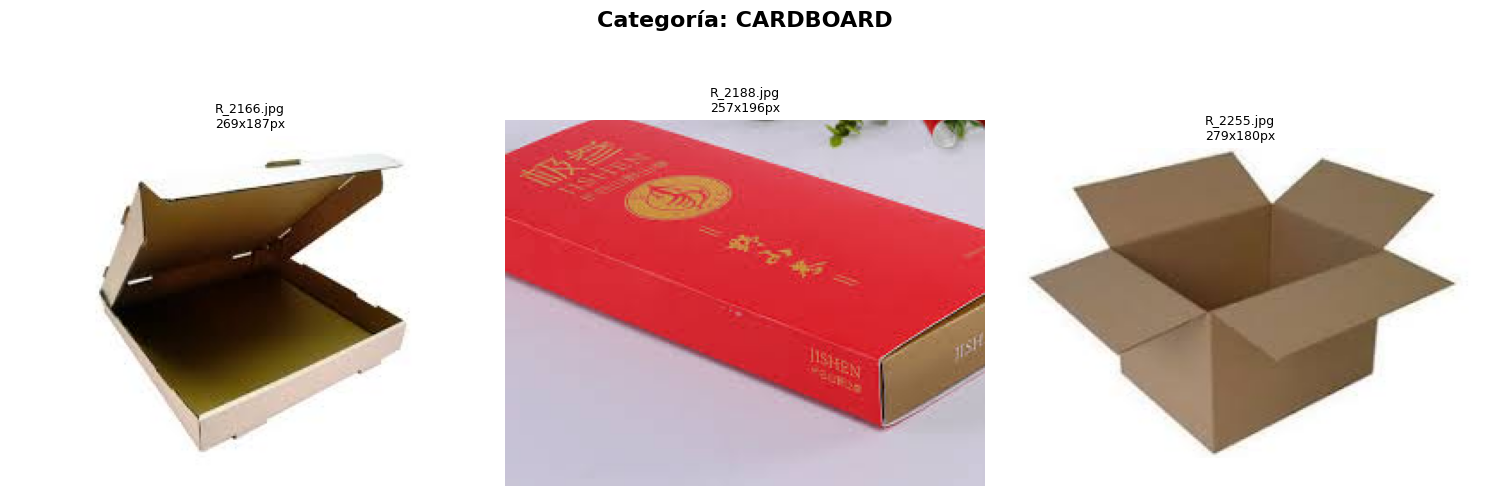

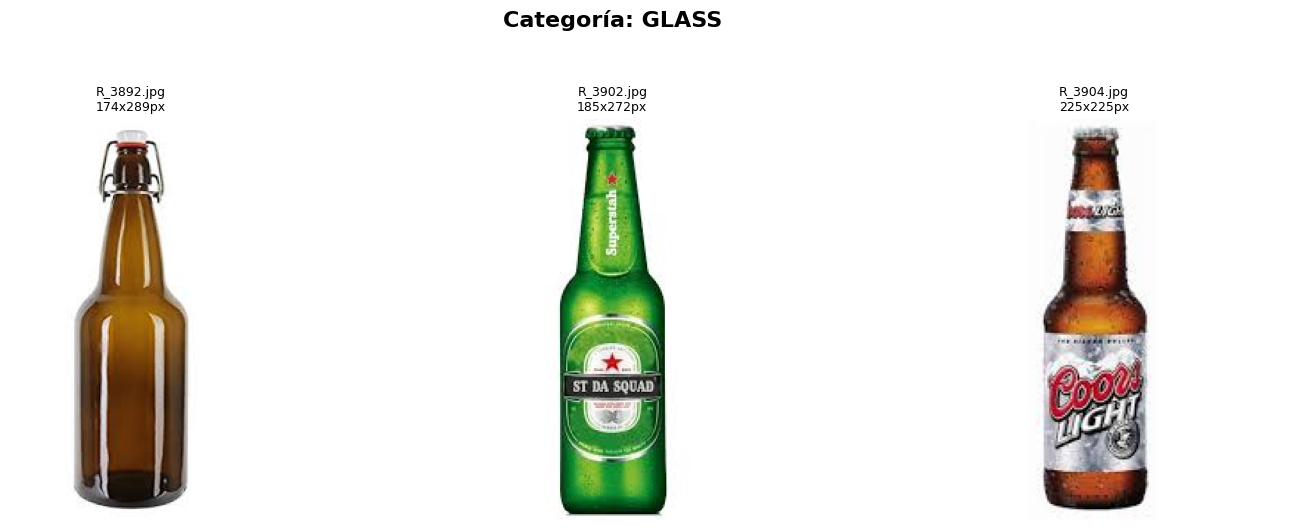

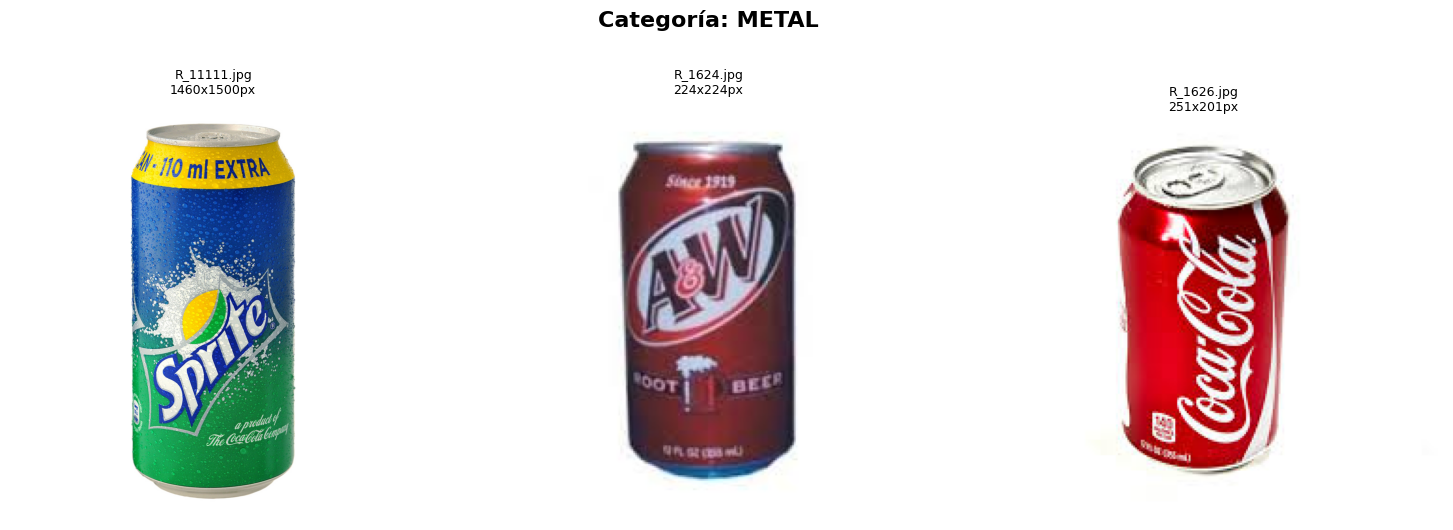

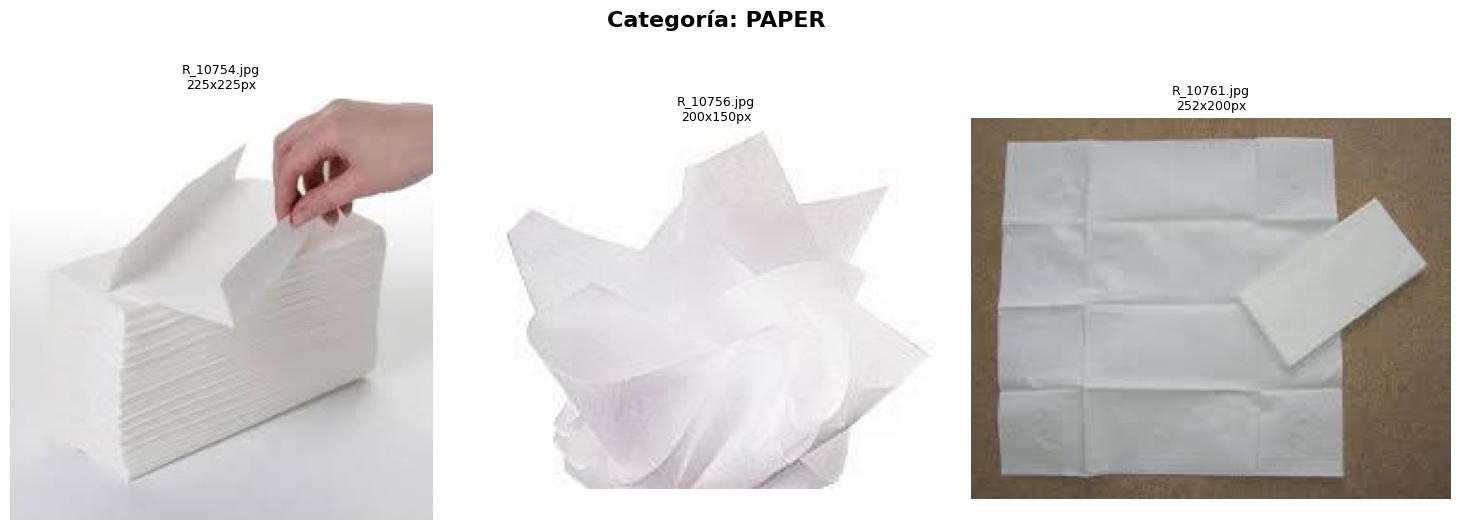

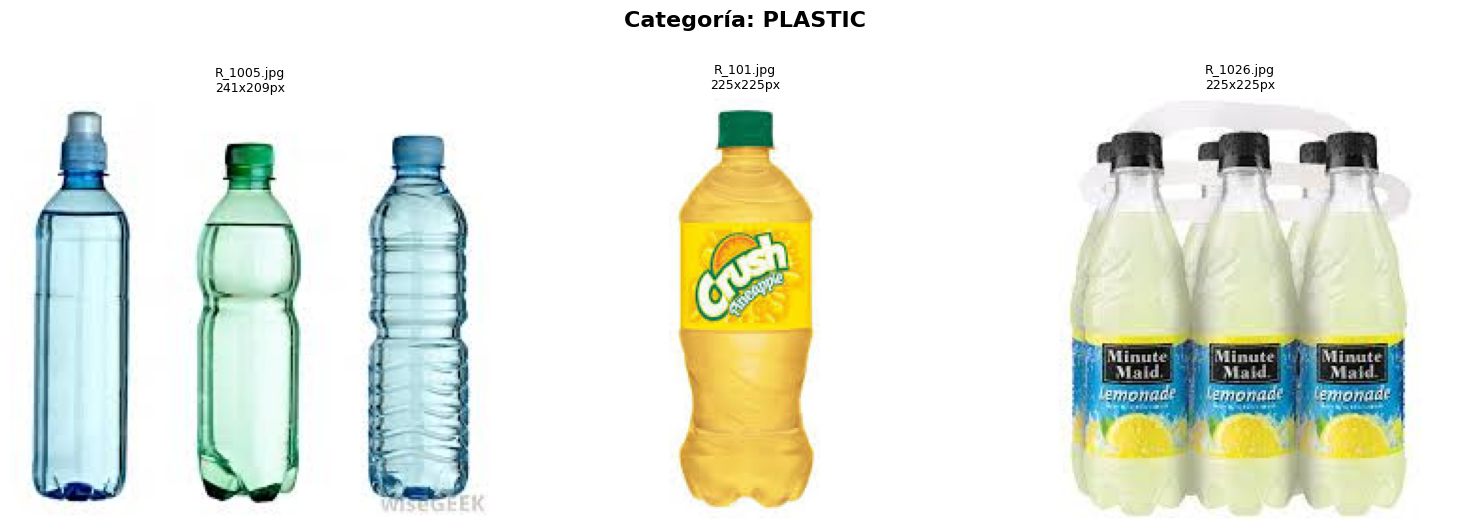

In [ ]:
# Visualización de muestras
print("\n🎨 MUESTRAS VISUALES")
for category in counts.keys():
    display_category_samples(dataset_dir, category, num_samples=3)

# 2. Preprocesamiento de los datos

* Parametros de entrenamiento 3500 (70%) para entrenar 1500 (30%) para validar

* tamaño de imagen para entrenar 224x224

* Normalizacion de datos

* Zoom y desplazamientos de imagenes

* Batch size optimizado para GPU

* Shuffle solo para datos de entrenamiento



In [ ]:
# Configuración aumentos de datos
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=False,  # Menos relevante para objetos de reciclaje
    brightness_range=[0.9, 1.1],
    validation_split=0.3
)

# Generadores de datos
img_size = (224, 224)
batch_size = 64

train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    color_mode='rgb'
)

val_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    color_mode='rgb'
)

Found 3500 images belonging to 5 classes.
Found 1500 images belonging to 5 classes.


# 3. Construir el modelo

In [ ]:
def build_optimized_model(input_shape=(224, 224, 3), num_classes=5):
    # Cargar MobileNetV2 pre-entrenado
    base_model = MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet',
        alpha=1.0  # Versión completa
    )

    # Congelar capas base
    for layer in base_model.layers[:130]:
        layer.trainable = False

    # Capas personalizadas
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.6),
        Dense(256,
              activation='relu',
              kernel_regularizer=l2(0.01),
              bias_regularizer=l2(0.01)),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')
    ])
    # Optimizador configurado
    optimizer = Adam(
        learning_rate=1e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False
    )

    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

model = build_optimized_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,588,229 (9.87 MB)

 Trainable params: 1,689,733 (6.45 MB)

 Non-trainable params: 898,496 (3.43 MB)

# 4. Entrenar el modelo

In [ ]:
# Callbacks mejorados
callbacks = [
    EarlyStopping(
        monitor='val_precision',
        patience=10,
        mode='max',
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=os.path.join(model_dir, 'best_model_reciclaje.keras'),
        monitor='val_recall',
        save_best_only=True,
        mode='max'
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    )
]

# Pesos de clases para balanceo
class_weights = {0: 1.1, 1: 1.2, 2: 1.0, 3: 1.0, 4: 1.1}  # Ajustar según necesidad

# Entrenamiento
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=val_generator,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.3913 - loss: 6.0029 - precision: 0.4676 - recall: 0.2968 - val_accuracy: 0.6520 - val_loss: 5.0617 - val_precision: 0.7264 - val_recall: 0.5753 - learning_rate: 1.0000e-04
Epoch 2/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 85s 2s/step - accuracy: 0.7472 - loss: 4.8525 - precision: 0.7996 - recall: 0.6869 - val_accuracy: 0.7053 - val_loss: 4.8516 - val_precision: 0.7421 - val_recall: 0.6600 - learning_rate: 1.0000e-04
Epoch 3/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.7896 - loss: 4.5778 - precision: 0.8316 - recall: 0.7536 - val_accuracy: 0.7033 - val_loss: 4.7851 - val_precision: 0.7271 - val_recall: 0.6767 - learning_rate: 1.0000e-04
Epoch 4/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.8469 - loss: 4.2942 - precision: 0.8774 - recall: 0.8240 - val_accuracy: 0.7213 - val_loss: 4.6908 - val_precision: 0.7405 - val_recall: 0.7000 - learning_rate: 1.0000e-04
Epoch 5/40
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - ac

# 5. Visualizacion de resultados

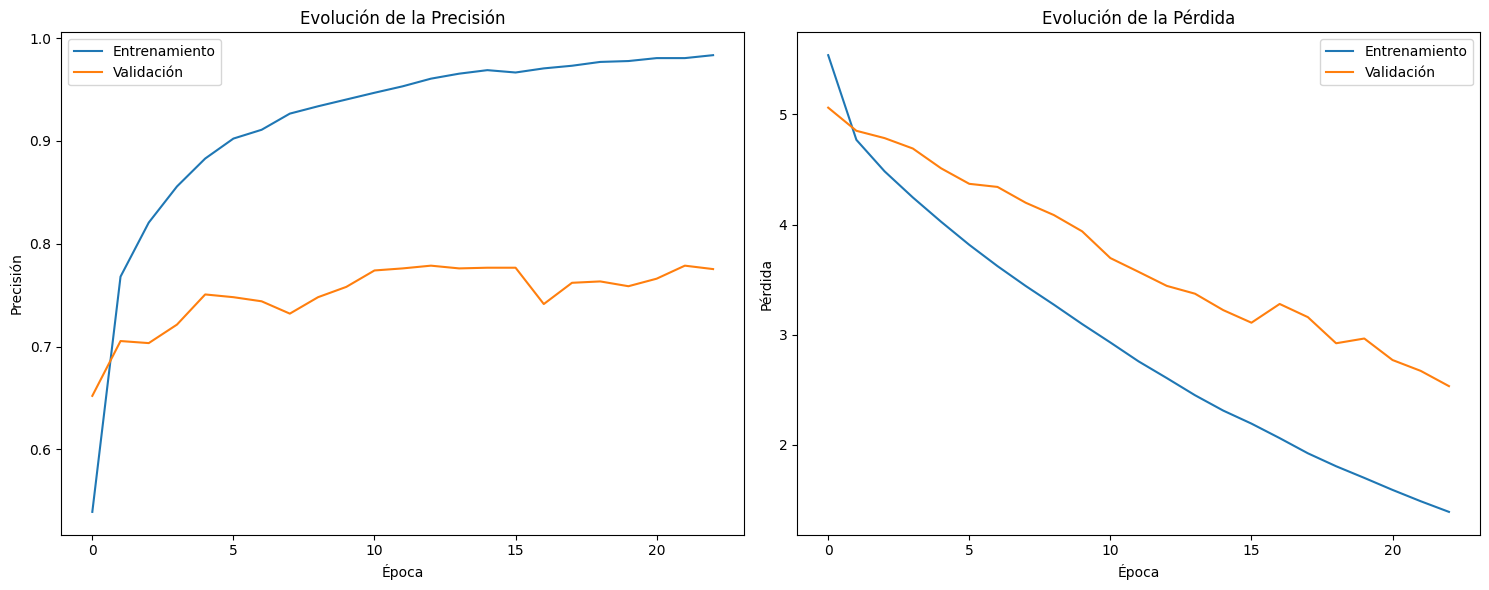

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(15, 6))

    # Gráfico de precisión
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Entrenamiento')
    plt.plot(history.history['val_accuracy'], label='Validación')
    plt.title('Evolución de la Precisión')
    plt.ylabel('Precisión')
    plt.xlabel('Época')
    plt.legend()

    # Gráfico de pérdida
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Entrenamiento')
    plt.plot(history.history['val_loss'], label='Validación')
    plt.title('Evolución de la Pérdida')
    plt.ylabel('Pérdida')
    plt.xlabel('Época')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [ ]:
# Generar reporte de clasificación
val_preds = model.predict(val_generator)
val_preds = np.argmax(val_preds, axis=1)

print("\n📝 Reporte de Clasificación:")
print(classification_report(val_generator.classes, val_preds, target_names=val_generator.class_indices.keys()))

24/24 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step

📝 Reporte de Clasificación:
              precision    recall  f1-score   support

   cardboard       0.75      0.86      0.80       300
       glass       0.85      0.60      0.71       300
       metal       0.69      0.84      0.76       300
       paper       0.91      0.71      0.80       300
     plastic       0.73      0.84      0.78       300

    accuracy                           0.77      1500
   macro avg       0.79      0.77      0.77      1500
weighted avg       0.79      0.77      0.77      1500



# 6. Exportacion del modelo

In [ ]:
# Guardar modelo final
model.save('modelo_reciclaje_v3.keras')
print("Modelo guardado")


Modelo guardado


In [ ]:
files.download('modelo_reciclaje_v3.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>